In [1]:
import torch
import torch.nn.functional as F
import cv2
from common import get_cfg, prepare_val
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from  cross_view_transformer.data.common import INTERPOLATION, get_view_matrix, get_pose, get_split 

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]

def to_image(x):
    return (255 * x).byte().cpu().numpy().transpose(1, 2, 0)

def resize(src, dst=None, shape=None, idx=0):
    if dst is not None:
        ratio = dst.shape[idx] / src.shape[idx]

    elif shape is not None:
        ratio = shape[idx] / src.shape[idx]

    width = int(ratio * src.shape[1])
    height = int(ratio * src.shape[0])

    return cv2.resize(src, (width, height), interpolation=cv2.INTER_CUBIC)

def draw_img(image,right=None):
    imgs = [to_image(image[0][i]) for i in range(image.shape[1])]
    if len(imgs) == 6:
        a = np.hstack(imgs[:3])
        b = np.hstack(imgs[3:])
        if right is None:
            return np.vstack((a, b))
        else:
            left = resize(np.vstack((a, b)), right)
            left = resize(np.vstack((a, b)),right)
    else:
        left = np.hstack([resize(x, right) for x in imgs])
    return np.hstack((left, right))
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]

/home/hcis-s20/miniconda3/envs/petr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
version = 'cvt_labels_nuscenes_v4'
cfg1 = get_cfg(DATASET_DIR, version, 'autoencoder') # cvt_nuscenes_multiclass
device = torch.device('cpu') # cuda:5
# best resnet: 0830_232653, origin cvt: 0824_024032
CHECKPOINT_PATH = '../logs/cross_view_transformers_test/0222_233207/checkpoints/last.ckpt'
model, network, loader, viz, _ = prepare_val(cfg1,device,CHECKPOINT_PATH,mode='split',batch_size=2)

Dataset length: 49
Loaded checkpoint.


In [6]:
network.to(device)
network.eval()
l = []
with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i == 3:
            break
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
        l.append(batch)
                
        # pred = network.encode(batch['bev'])
        # l.append([batch,pred,network.prediction(pred)])

In [7]:
import mmcv
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.nuscenes import NuScenes
import numpy as np

nusc = NuScenes(version='v1.0-trainval', dataroot='/media/hcis-s20/SRL/nuscenes/trainval/', verbose=True)
bevformer_results = mmcv.load("/media/hcis-s20/SRL/det3d/BEVFormer/test/bevformer_base/Wed_Mar__6_21_42_43_2024/pts_bbox/results_nusc.json")

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 30.898 seconds.
Reverse indexing ...
Done reverse indexing in 7.9 seconds.


In [55]:
def quaternion_yaw(q: Quaternion) -> float:
    """
    Calculate the yaw angle from a quaternion.
    See https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles.
    :param q: Quaternion of interest.
    :return: Yaw angle in radians.
    """

    a = 2.0 * (q[0] * q[3] + q[1] * q[2])
    b = 1.0 - 2.0 * (q[2] ** 2 + q[3] ** 2)

    return np.arctan2(a, b)

class cvt_nusc_helper:
    CAMERAS = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
               'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
    def __init__(self,nusc,bev={'h': 200, 'w': 200, 'h_meters': 100, 'w_meters': 100, 'offset': 0.0}):
        self.nusc = nusc
        self.view = get_view_matrix(flip=False,**bev)

    def reset_calculation(self):
        import copy
        vis = {'2':[0,0],'3':[0,0],'4':[0,0]}
        meters = {0:[0,0],1:[0,0],2:[0,0],3:[0,0],4:[0,0],5:[0,0]}
        self.calculation = {'visibility':vis,'meters':meters}
        # for k in self.calculation:
        #     for i in np.linspace(0.2,0.7,6):
        #         self.calculation[k][str(i)] = copy.deepcopy(vis) if k == 'visibility' else copy.deepcopy(meters)
        self.tp_fn = [0,0]
        self.semantics = 0.0
        self.distance = 0.0
        self.scores = []
        self.visibility_token = []
        self.distances = []
        self.vis_4 = [0.0,0.0]

    def parse_pose(self, record, *args, **kwargs):
        return get_pose(record['rotation'], record['translation'], *args, **kwargs)    
    
    def get_category_index(self, name, categories):
        """
        human.pedestrian.adult
        """
        tokens = name.split('.')

        for i, category in enumerate(categories):
            if category in tokens:
                return i

        return None

    def convert_to_box(self, sample, annotations):
        # Import here so we don't require nuscenes-devkit unless regenerating labels
        from nuscenes.utils import data_classes

        V = self.view
        M_inv = np.array(sample['pose_inverse'])
        S = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ])

        for a in annotations:
            box = data_classes.Box(a['translation'], a['size'], Quaternion(a['rotation']))

            corners = box.bottom_corners()                                              # 3 4
            center = corners.mean(-1)                                                   # 3
            front = (corners[:, 0] + corners[:, 1]) / 2.0                               # 3
            left = (corners[:, 0] + corners[:, 3]) / 2.0                                # 3

            p = np.concatenate((corners, np.stack((center, front, left), -1)), -1)      # 3 7
            p = np.pad(p, ((0, 1), (0, 0)), constant_values=1.0)                        # 4 7
            p = V @ S @ M_inv @ p                                                       # 3 7

            yield p, a['visibility_token'], a['category_name']
    def get_view_matrix(h=200, w=200, h_meters=100.0, w_meters=100.0, offset=0.0, flip=False):
        sh = h / h_meters
        sw = w / w_meters

        if flip:
            return np.float32([
                [ sw, 0,          w/2.],
                [0,  -sh, h*offset+h/2.],
                [ 0.,  0.,            1.]
            ])
        else:
            return np.float32([
                [ 0., -sw,          w/2.],
                [-sh,  0., h*offset+h/2.],
                [ 0.,  0.,            1.]
            ])
    
    def convert_to_box_tri(self, sample, annotations,mode_in):
        # Import here so we don't require nuscenes-devkit unless regenerating labels
        from nuscenes.utils import data_classes
        def get_view():
            mode, h, w = mode_in
            h_meters = 100 if h == 200 else 6
            w_meters = 100 if w == 200 else 6
            sh = h / h_meters
            sw = w / w_meters
            if mode == 0:
                return np.float32([
                [ 0., -sw,          w/2.],
                [-sh,  0.,          h/2.],
                [ 0.,  0.,            1.]
            ])
            elif mode == 1:
                return np.float32([
                [ -sw,  0.,          w/2.],
                [ 0., -sh,           h/2.],
                [ 0.,  0.,            1.]
            ])
            else:
                return np.float32([
                [-sw,  0.,          w/2.],
                [ 0., -sh,          h/2.],
                [ 0.,  0.,            1.]
            ])

        M_inv = np.array(sample['pose_inverse'])
        if mode_in[0] == 0:
            S = np.array([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1],
            ])
        elif mode_in[0] == 1:
            S = np.array([
                [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
            ])
        else:
            S = np.array([
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
            ])
        V = get_view()

        for a in annotations:
            box = data_classes.Box(a['translation'], a['size'], Quaternion(a['rotation']))
            if mode_in[0] == 0:
                corners_index = [2, 3, 7, 6]
            elif mode_in[0] == 1:
                corners_index = [0, 4, 7, 3]
            else:
                corners_index = [2, 3, 0, 1]

            corners = box.corners()[:, corners_index]                                    # 3 4
            center = corners.mean(-1)                                                   # 3
            front = (corners[:, 0] + corners[:, 1]) / 2.0                               # 3
            left = (corners[:, 0] + corners[:, 3]) / 2.0                                # 3

            p = np.concatenate((corners, np.stack((center, front, left), -1)), -1)      # 3 7
            p = np.pad(p, ((0, 1), (0, 0)), constant_values=1.0)                        # 4 7
            p = V @ S @ M_inv @ p                                                       # 3 7

            yield p

    def get_annotations_by_category(self, sample, categories):
        result = [[] for _ in categories]

        for ann_token in self.nusc.get('sample', sample['token'])['anns']:
            a = self.nusc.get('sample_annotation', ann_token)
            idx = self.get_category_index(a['category_name'], categories)
            if idx is None:
                continue
            result[idx].append(a)

        return result

    def get_triview(self,sample,anns_by_category):
        # 0: bev, 1: side, 2: front
        result = []
        for i in range(3):
            if i == 0:
                h, w = 200, 200
            elif i == 1:
                h, w = 48, 200
            else:
                h, w = 48, 200

            tmp_result = list()

            for anns in anns_by_category:
                render = np.zeros((h, w), dtype=np.uint8)

                for p in self.convert_to_box_tri(sample, anns,[i,h,w]):
                    p = p[:2, :4]

                    cv2.fillPoly(render, [p.round().astype(np.int32).T], 1, INTERPOLATION)

                tmp_result.append(render)

            result.append(255 * np.stack(tmp_result, -1))
        return result

    def get_dynamic_layers(self, sample, anns_by_category):
        h, w = 200, 200# self.bev_shape[:2]
        result = list()

        for anns in anns_by_category:
            render = np.zeros((h, w), dtype=np.uint8)

            for p, vis, category in self.convert_to_box(sample, anns):
                p = p[:2, :4]
                # if (p<0).any() or (p>200).any():
                #     continue
                cv2.fillPoly(render, [p.round().astype(np.int32).T], 1, cv2.LINE_8)#, INTERPOLATION)

                # result.append(render)
                result.append({'p':p.round().astype(np.int32).T,'vis':vis,'category':category, 'bev':render})

        # return 255 * np.stack(result, -1)
        return result

    def parse_sample_record(self, sample_record, camera_rig=[0, 1, 2, 3, 4, 5]):
        lidar_record = self.nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])

        # calibrated_lidar = self.nusc.get('calibrated_sensor', lidar_record['calibrated_sensor_token'])
        egolidar = self.nusc.get('ego_pose', lidar_record['ego_pose_token'])

        # world_from_lidarflat = self.parse_pose(calibrated_lidar, flat=True)
        # lidarflat_from_world = self.parse_pose(calibrated_lidar, flat=True,inv=True)

        world_from_egolidarflat = self.parse_pose(egolidar, flat=True)
        egolidarflat_from_world = self.parse_pose(egolidar, flat=True, inv=True)

        cam_channels = []
        intrinsics = []
        extrinsics = []

        for cam_idx in camera_rig:
            cam_channel = self.CAMERAS[cam_idx]
            cam_token = sample_record['data'][cam_channel]

            cam_record = self.nusc.get('sample_data', cam_token)
            egocam = self.nusc.get('ego_pose', cam_record['ego_pose_token'])
            cam = self.nusc.get('calibrated_sensor', cam_record['calibrated_sensor_token'])

            cam_from_egocam = self.parse_pose(cam, inv=True)
            egocam_from_world = self.parse_pose(egocam, inv=True)

            E = cam_from_egocam @ egocam_from_world @ world_from_egolidarflat # @ world_from_lidarflat
            I = cam['camera_intrinsic']

            cam_channels.append(cam_channel)
            intrinsics.append(I)
            extrinsics.append(E.tolist())

        return {
            'token': sample_record['token'],

            'pose': world_from_egolidarflat.tolist(),
            'pose_inverse': egolidarflat_from_world.tolist(),

            'cam_ids': list(camera_rig),
            'cam_channels': cam_channels,
            'intrinsics': intrinsics,
            'extrinsics': extrinsics,
        }
    def tmp(self, sample_record, categories):
        from nuscenes.utils.data_classes import Box

        lidar_record = self.nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])

        # calibrated_lidar = self.nusc.get('calibrated_sensor', lidar_record['calibrated_sensor_token'])
        egolidar = self.nusc.get('ego_pose', lidar_record['ego_pose_token'])

        # world_from_lidarflat = self.parse_pose(calibrated_lidar, flat=True)
        # lidarflat_from_world = self.parse_pose(calibrated_lidar, flat=True,inv=True)

        world_from_egolidarflat = self.parse_pose(egolidar, flat=True)
        egolidarflat_from_world = self.parse_pose(egolidar, flat=True, inv=True)
        boxs = []
        for ann_token in self.nusc.get('sample', sample_record['token'])['anns']:
            annotation = self.nusc.get('sample_annotation', ann_token)
            idx = self.get_category_index(annotation['category_name'], categories)
            if idx is None:
                continue
            box = Box(annotation['translation'], annotation['size'], Quaternion(annotation['rotation']))
            box.translate(-np.array(egolidar['translation']))
            box.rotate(Quaternion(egolidar['rotation']).inverse)
            boxs.append(box)
            # print(box.bottom_corners())
            # print(quaternion_yaw(box.orientation))
            # print((box.orientation.yaw_pitch_roll[0]))
        return boxs

    def get_sample(self,token):
        return self.nusc.get('sample', token)
    
    def calculate_per_annotation(self,token,pred,vis):
        def calculate_distance(p):
            min_x, max_x = 201,-1
            min_y, max_y = 201,-1
            for _p in p:
                x,y = _p
                if x<0 or y<0 or y>200 or x >200:
                    print(x,y)
                if x>max_x:
                    max_x = x
                if x<min_x:
                    min_x = x
                if y>max_y:
                    max_y = y
                if y<min_y:
                    min_y = y
            center_x, center_y = (min_x+max_x)/2.0, (min_y+max_y)/2.0
            return np.sqrt((center_x-99)**2+(center_y-99)**2)/2.0

        sample = self.get_sample(token)
        sample = self.parse_sample_record(sample)
        anns_dynamic = self.get_annotations_by_category(sample, DYNAMIC)
        dynamic = self.get_dynamic_layers(sample, anns_dynamic)
        flag = False
        total_positive = 0.0
        predicted_positive = pred.sum()
        for ann in dynamic:
            render = np.zeros((200, 200), dtype=np.uint8)
            cv2.fillPoly(render, [ann['p']], 1, INTERPOLATION)
            distance = calculate_distance(ann['p'])
            distance_index = distance//10
            distance_index = 5 if distance_index>=5 else distance_index
            a = render.sum()
            b = (np.logical_and(render,pred)).sum()
            total_positive += a
            self.tp_fn[0] += a
            self.tp_fn[1] += b
            self.calculation['visibility'][ann['vis']][1] += 1
            self.calculation['meters'][distance_index][1] += 1
            self.scores.append(round(b/a,1))
            self.visibility_token.append(ann['vis'])
            self.distances.append(distance_index)
            if b/a >= 0.5:
                self.calculation['visibility'][ann['vis']][0] += 1
                self.calculation['meters'][distance_index][0] += 1
                predicted_positive -= a
                if ann['vis'] == '4':
                    vis -= render
                    self.vis_4[0] += 1
            else:
                if ann['vis'] == '4':
                    flag = True
                    self.vis_4[1] += 1
        return flag,vis
    
    def get_cam_images(self,sample):
        from PIL import Image
        imgs = []
        CAM = ['CAM_FRONT_LEFT','CAM_FRONT','CAM_FRONT_RIGHT','CAM_BACK_LEFT','CAM_BACK','CAM_BACK_RIGHT']
        for s in CAM:
            sample_data = self.nusc.get('sample_data',sample['data'][s])
            array = np.asarray(Image.open(osp.join(self.nusc.dataroot, sample_data['filename'])))
            imgs.append(array)
        a = np.hstack(imgs[:3])
        b = np.hstack(imgs[3:])
        return np.vstack((a, b))

    def get_lidar_points(self,token):
        from nuscenes.utils.data_classes import LidarPointCloud
        sample_rec = self.nusc.get('sample', token)
        min_distance = 0.5

        sample_data_token = sample_rec['data']['LIDAR_TOP']
        current_sd_rec = self.nusc.get('sample_data', sample_data_token)
        # Load up the pointcloud and remove points close to the sensor.
        current_pc = LidarPointCloud.from_file(os.path.join(self.nusc.dataroot, current_sd_rec['filename']))
        current_pc.remove_close(min_distance)

        # Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
        current_cs_rec = self.nusc.get('calibrated_sensor', current_sd_rec['calibrated_sensor_token'])
        car_from_current = self.parse_pose(current_cs_rec)

        current_pc.transform(car_from_current)

        return current_pc.points


cvt_helper = cvt_nusc_helper(nusc)

In [92]:
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction',
    'pedestrian',
    'motorcycle', 'bicycle',
    'emergency',
]
DYNAMIC = ['car']
sample = cvt_helper.get_sample(l[0]['token'][0])
sample_record = cvt_helper.parse_sample_record(sample)
anns_dynamic = cvt_helper.get_annotations_by_category(sample_record, DYNAMIC)

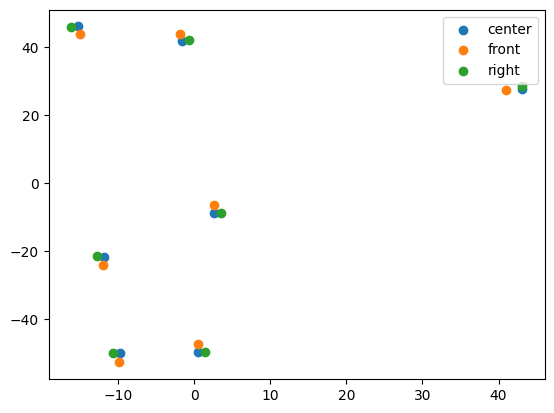

In [113]:
sample = cvt_helper.get_sample(l[0]['token'][0])
boxs = cvt_helper.tmp(sample, DYNAMIC)
centers = []
fronts = []
lefts = []
yaws = []
for box in boxs:
    corners = box.bottom_corners()[:2]
    x_, y_ = corners.mean(-1)
    front = (corners[:, 0] + corners[:, 1]) / 2.0                               # 3
    left = (corners[:, 0] + corners[:, 3]) / 2.0                                # 3
    if x_ > 55 or x_ < -55:
        continue
    if y_ > 55 or y_ < -55:
        continue
    centers.append(corners.mean(-1))
    fronts.append(front)
    lefts.append(left)
    yaws.append(box.orientation.yaw_pitch_roll[0])
    # print(box.bottom_corners().shape)
    # print(quaternion_yaw(box.orientation))
    # print((box.orientation.yaw_pitch_roll[0]))
centers = np.array(centers)
fronts = np.array(fronts)
lefts = np.array(lefts)
plt.scatter(-centers[:,1],centers[:,0],label='center')
plt.scatter(-fronts[:,1],fronts[:,0],label='front')
plt.scatter(-lefts[:,1],lefts[:,0],label='right')
plt.legend()

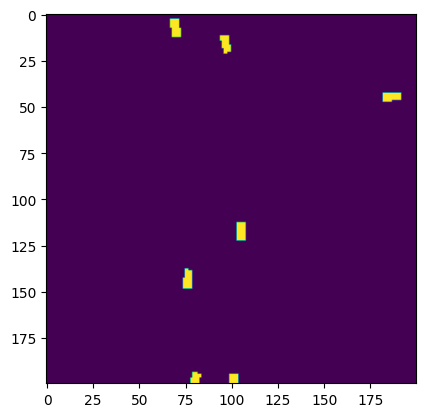

In [73]:
plt.imshow(l[0]['bev'][0,4])

In [78]:
corners = box.bottom_corners()
front = (corners[:, 0] + corners[:, 1]) / 2.0                               # 3
left = (corners[:, 0] + corners[:, 3]) / 2.0                                # 3
print(front,left,corners)

[ 15.36739289 -63.06451495   0.22847867] [ 16.91496544 -67.99816419   0.18255049] [[ 16.71797221  14.01681357  14.41080004  17.11195868]
 [-63.0110746  -63.1179553  -73.09213446 -72.98525377]
 [  0.19711574   0.25984159   0.23071109   0.16798524]]


In [124]:
for center, front, left, yaw in zip(centers,fronts,lefts,yaws):
    rotation = np.array([
        [np.cos(yaw),-np.sin(yaw)],
        [np.sin(yaw),np.cos(yaw)]
    ])
    print("Origin:")
    print(np.expand_dims(center,1),np.expand_dims(front,1),np.expand_dims(left,1))
    points = rotation @ np.concatenate((np.expand_dims(center,1),np.expand_dims(front,1),np.expand_dims(left,1)),1)
    print("Rotated:")
    print(points)

Origin:
[[-21.67296211]
 [ 11.85657408]] [[-24.04248664]
 [ 12.02283974]] [[-21.60869775]
 [ 12.77232185]]
Rotated:
[[ 20.78952025  23.14158582  20.66128955]
 [-13.34509211 -13.67687263 -14.25409198]]
Origin:
[[-50.03889145]
 [  9.70837698]] [[-52.83567228]
 [  9.874909  ]] [[-49.97818978]
 [ 10.72757074]]
Rotated:
[[ 49.37297903  52.15490639  49.25177405]
 [-12.66697214 -12.99953201 -13.68075218]]
Origin:
[[-49.72834071]
 [ -0.49529981]] [[-47.36700892]
 [ -0.50654096]] [[-49.73293378]
 [ -1.45128707]]
Rotated:
[[-49.73014675 -47.36889626 -49.73933402]
 [ -0.2563112   -0.27890024  -1.21226535]]
Origin:
[[-8.74906782]
 [-2.55797568]] [[-6.48528713]
 [-2.57966084]] [[-8.75777405]
 [-3.46293238]]
Rotated:
[[-8.7732775  -6.50981028 -8.79069149]
 [-2.47366718 -2.51713513 -3.3784982 ]]
Origin:
[[46.1600176]
 [15.2252053]] [[43.86325827]
 [15.07167495]] [[46.09899788]
 [16.13916484]]
Rotated:
[[-45.04291926 -42.76149469 -44.92113484]
 [-18.26717071 -17.96094049 -19.17503303]]
Origin:
[[41.89

In [119]:
a = np.array([1,2])
np.expand_dims(a,1).shape

AttributeError: 'numpy.ndarray' object has no attribute 'expand_dims'